## Prepare image data to TFRecords

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import os
import numpy as np
import skimage.io as io
import PIL
from PIL import Image
from random import shuffle
%matplotlib inline
print(tf.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


1.4.0-rc0


In [2]:
# url = "http://download.tensorflow.org/data/flowers.tar.gz"
# flowers_data_dir = '/home/robin/dataset'

# if not tf.gfile.Exists(flowers_data_dir):
#     tf.gfile.MakeDirs(flowers_data_dir)
# dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

In [3]:
DATASET_PATH = '/home/robin/dataset/flower_photos/'
N_CLASSES = 2
IMG_HEIGHT = 299
IMG_WIDTH = 299
CHANNELS = 3

In [4]:
def read_images(dataset_path, batch_size):
    train_data, test_data = list(), list()
    
    label = 0
    try:
        classes = sorted(os.walk(dataset_path).next()[1])
    except Exception:
        classes = sorted(os.walk(dataset_path).__next__()[1])
    for c in classes:
        image_path_lables = list()
        c_dir = os.path.join(dataset_path, c)
        try:
            walk = os.walk(c_dir).next()
        except Exception:
            walk = os.walk(c_dir).__next__()
        for sample in walk[2]:
            if sample.endswith('.jpg') or sample.endswith('.jpeg') or sample.endswith('.png'):
                image_path_lables.append((os.path.join(c_dir, sample), label))
        shuffle(image_path_lables)
        train_num = int(len(image_path_lables)*0.8)
        train_data.extend(image_path_lables[:train_num])
        test_data.extend(image_path_lables[train_num:])
        label += 1
    return (train_data, test_data)

train_data, test_data = read_images(DATASET_PATH, 32)

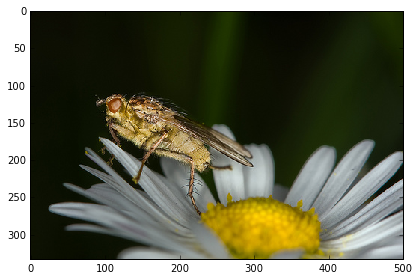

In [5]:
io.imshow(train_data[0][0])

In [6]:
print(len(train_data), len(test_data))

2934 736


In [9]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def save_to_tfrecords(dataset, tfrecords_filename):
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    img_id = 0
    for img_path, label in dataset:
#         img = Image.open(img_path).resize([299, 299], PIL.Image.BILINEAR)
        img = Image.open(img_path).resize([299, 299], PIL.Image.BILINEAR)
        img = np.array(img)
        height = img.shape[0]
        width = img.shape[1]
        img_raw = img.tostring()
#         img_raw = img
        img_id += 1
        example = tf.train.Example(features = tf.train.Features(feature={
            'height': _int64_feature(height),
            'width' : _int64_feature(width),
            'image_raw': _bytes_feature(img_raw),
            'lable': _int64_feature(label),
            'img_id': _int64_feature(img_id)
        }))

        writer.write(example.SerializeToString())
    writer.close()    

# tfrecords_filename = 
save_to_tfrecords(train_data, './retrain_flowers/flower_train_1.tfrecords')
save_to_tfrecords(test_data, './retrain_flowers/flower_test_1.tfrecords')

In [ ]:
reconstructed_images = []
reconstructed_lables = []
tfrecords_filename = './retrain_flowers/flower_train.tfrecords'
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    label  = int(example.features.feature['lable']
                                .int64_list
                                .value[0])
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    reconstructed_lables.append(label)
    
    reconstructed_images.append(reconstructed_img)

In [ ]:
io.imshow(reconstructed_images[0])

In [ ]:
io.imshow(reconstructed_images[76])

In [ ]:
print(reconstructed_images[0].dtype)

In [ ]:
print(len(reconstructed_lables))
print(reconstructed_lables)

In [28]:
batch_size = 76
import numpy as np

def gen_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    input_mean = 128
    input_std = 128
    def parser(record):
        keys_to_features = {
          'height': tf.FixedLenFeature((), tf.int64),
          'width': tf.FixedLenFeature((), tf.int64),
          'image_raw': tf.FixedLenFeature((), tf.string),
          'lable': tf.FixedLenFeature((), tf.int64),
          'img_id': tf.FixedLenFeature((), tf.int64)
        }
        parsed = tf.parse_single_example(record, keys_to_features)
        image = parsed["image_raw"]
        image = tf.decode_raw(image, tf.uint8)
        image = tf.reshape(image, [299, 299, 3])
        image = tf.cast(image, tf.float32)
        image = tf.subtract(image, input_mean)
        image = tf.multiply(image, 1.0/input_std)
        label = tf.cast(parsed["lable"], tf.int32)
        img_id = tf.cast(parsed["img_id"], tf.int32)
        return image, label, img_id
    
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=300)
    dataset = dataset.batch(batch_size)
    return dataset

In [29]:
import time
start = time.time()
train_dataset   = gen_dataset(['./retrain_flowers/flower_train_1.tfrecords'])
train_iterator  = train_dataset.make_initializable_iterator()
next_train_batch  = train_iterator.get_next()

val_dataset     = gen_dataset(['./retrain_flowers/flower_test_1.tfrecords'])
val_iterator    = val_dataset.make_initializable_iterator()
next_val_batch  = val_iterator.get_next()
   
img1 = []
label1 = []
ids = []
img2 = []
label2 = []
# with tf.Session() as sess:
sess = tf.Session()
sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
sess.run(train_iterator.initializer)
sess.run(val_iterator.initializer)
while True:
    try:
        train_img, train_lable, img_id = sess.run(next_train_batch)
#         val_img, val_label = sess.run(next_val_batch)
#         img1.extend(train_img)
        label1.extend(train_lable)
        ids.extend(img_id)
#         img2
    except:
        break
print('time used: ', time.time() - start)    
# print(lable)

time used:  6.97875618935


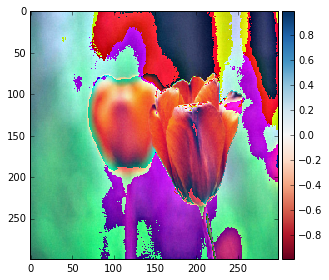

In [30]:
io.imshow(train_img[0])

In [34]:
print(len(ids))
print(len(set(ids)))
print(label1)

2934
2934
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,

In [ ]:
# io.imshow(val_img[0])

In [ ]:
train_img, train_lable = sess.run(next_train_batch)
val_img, val_label = sess.run(next_val_batch)

In [ ]:
io.imshow(train_img[0])